In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from utils.utils import open_4_channel
from utils.resnet import Resnet4Channel

In [3]:
path = Config.data_path()/'proteinatlas'

In [4]:
# label_df = pd.read_csv(path/'train.csv')

In [5]:
# label_df.head()

In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ', classes=[str(i) for i in range(28)])) # 27 classes

In [7]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [8]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [9]:
# test_fnames[:5]

In [10]:
src.add_test(test_fnames, label='0');
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [11]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [12]:
# get_transforms returns tfms for train & valid: https://docs.fast.ai/vision.transform.html#get_transforms
train_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                            max_lighting=0.05, max_warp=0.)
size = 128

In [13]:
data = (src.transform((train_tfms, _), size=size)
        .databunch().normalize(protein_stats))

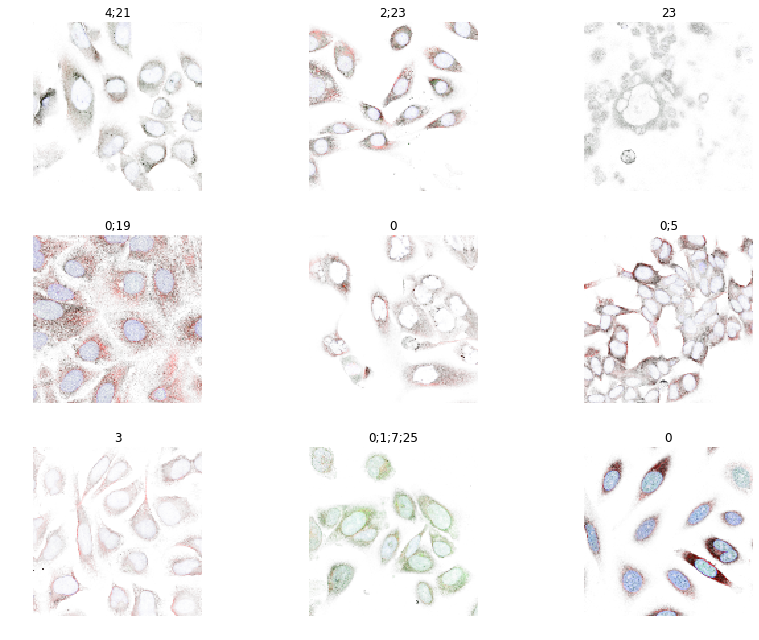

In [14]:
data.show_batch(rows=3, figsize=(12,9))

In [15]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [16]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6], m[1])

In [17]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [18]:
learn = create_cnn(
    data, 
    resnet50, 
    cut=-2, 
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path, 
    metrics=[f1_score]
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


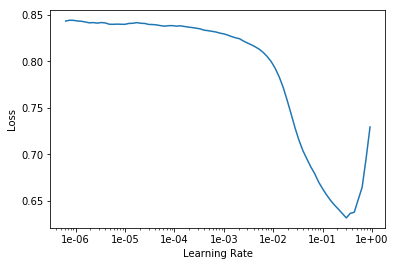

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 3e-2

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.154098,0.144676,0.456652
2,0.150340,0.147368,0.483441
3,0.138852,0.133052,0.518546
4,0.128695,0.122896,0.552855
5,0.122834,0.118658,0.577066


In [22]:
learn.save('stage-1-rn50-datablocks-sz128')

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


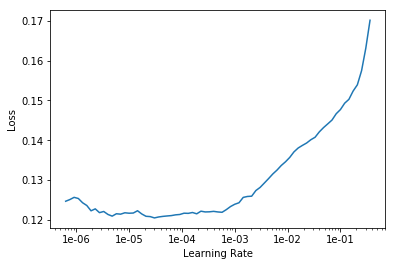

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.122032,0.119484,0.573136
2,0.124276,0.121466,0.561945
3,0.125240,0.124952,0.542730
4,0.123585,0.125676,0.552006
5,0.121753,0.120939,0.580173
6,0.119882,0.117670,0.582705
7,0.116195,0.112468,0.607217
8,0.113114,0.110549,0.609188
9,0.107278,0.110086,0.616795
10,0.106212,0.109549,0.629468


In [26]:
learn.save('stage-2-rn50-datablocks-sz128')

In [27]:
preds,_ = learn.get_preds(DatasetType.Test)

In [28]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]

In [29]:
import datetime; date = str(datetime.date.today()).replace('-','')

In [31]:
(path/'submissions').mkdir(exist_ok=True)

subm_msg = f"RN50 Datablocks codealong; fastai {__version__}; size 128; stage-2; threshold: 20%; date: {date}"
subm_name = f"rn50-datablocks-sz128-stg2-th20p-fastai-{__version__}-{date}.csv"

subm_df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
subm_df.to_csv(path/'submissions'/subm_name, header=True, index=False)

In [32]:
! kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/submissions/{subm_name} -m "{subm_msg}"

100%|█████████████████████████████████████████| 484k/484k [00:00<00:00, 497kB/s]
Successfully submitted to Human Protein Atlas Image Classification

## END